In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_indices
from deepexperiment.interpret import DeepShap

2022-10-17 15:32:02.679996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 15:32:02.801542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 15:32:02.801567: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-17 15:32:02.828061: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 15:32:03.370905: W tensorflow/stream_executor/platform/de

# Loading model and data

In [3]:
model = keras.models.load_model("../models/resnet_small_committee.h5")

2022-10-17 15:32:04.901501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/katarina/git/DeepExperiment/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-17 15:32:04.901538: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-17 15:32:04.901556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (katarina-lenovo): /proc/driver/nvidia/version does not exist
2022-10-17 15:32:04.901722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
samples = pd.read_csv('../data/evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
pos_samples = samples[samples['label'] == 1].reset_index(drop=True)
neg_samples = samples[samples['label'] == 0].reset_index(drop=True)

In [5]:
true_positive_indices = get_indices(pos_samples, model, lambda x: x[1] > x[0])
print(len(pos_samples))
print(len(true_positive_indices))

32/32 [==============================] - 2s 33ms/step
1000
552


In [6]:
data, _ = one_hot_encoding_batch(pos_samples.iloc[true_positive_indices].reset_index(drop=True))

# DeepSHAP

In [7]:
try:
    shaps = np.load('../data/evaluation_set_1_1_CLAHS2013_paper_shaps_tp.npy')
except:
    rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
    background, _ = one_hot_encoding_batch(rand_samples)
    deepShap = DeepShap(model, background)
    attribution = deepShap(data)
    pos_shaps = attribution[1][:,:,:,0]
    shaps = np.array(pos_shaps)
    np.save('../data/evaluation_set_1_1_CLAHS2013_paper_shaps_tp.npy', shaps)

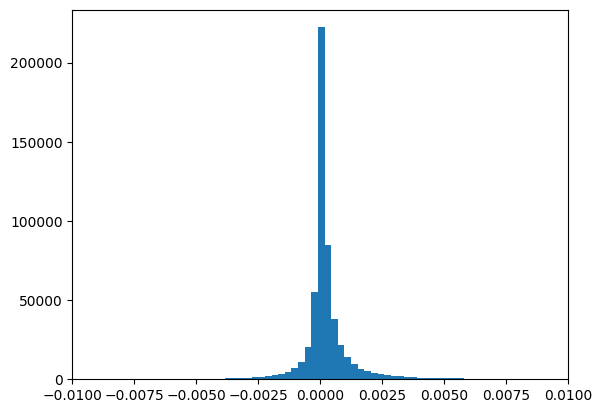

In [8]:
plt.hist(shaps.flatten(), bins=5000)
plt.xlim(xmin=-0.01, xmax = 0.01)
plt.show()

In [42]:
from deepexperiment.alignment import Attrament

attrament = Attrament()
align_x, align_s, align_y = [], [], []
for attr, index in zip(shaps, true_positive_indices):
    x, s, y = attrament(pos_samples.iloc[index]['gene'], pos_samples.iloc[index]['miRNA'][::-1], attr)
    align_x.append(x)
    align_s.append(s)
    align_y.append(y)

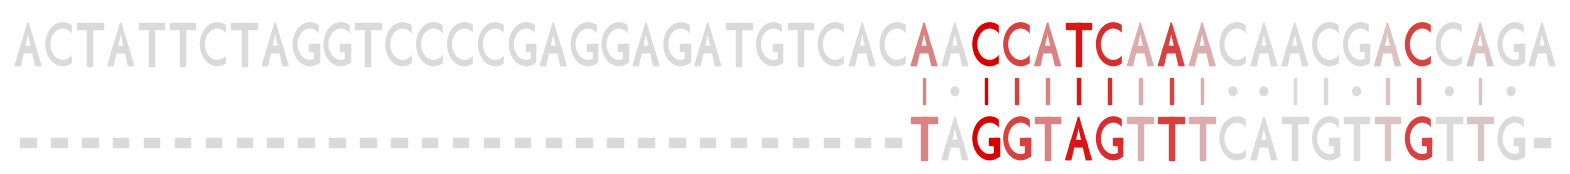

In [43]:
from deepexperiment.visualization import plot_alignment

plot_alignment(align_x[0], align_s[0], align_y[0])

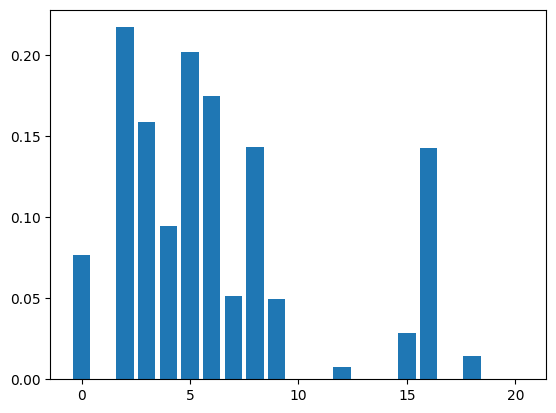

In [44]:
from deepexperiment.visualization import plotbar_miRNA_importance_w_spaces

plotbar_miRNA_importance_w_spaces(align_y[0], align_s[0])

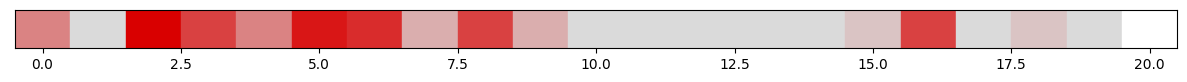

In [54]:
from deepexperiment.visualization import plot_miRNA_importance_w_spaces

plot_miRNA_importance_w_spaces(align_y[0], align_s[0])

# Clustering

In [77]:
miRNA_s = []
for j in range(len(align_y)):
    s = [align_s[j][i] for i in range(len(align_y[j])) if align_y[j][i] != "-"]
    # pad with zeros to the length of 20
    if len(s) < 20:
        s = s + [0] * (20 - len(s))
    miRNA_s.append(s)

In [79]:
miRNA_s = np.array(miRNA_s)

In [80]:
from sklearn.cluster import KMeans

N_CLUSTERS=10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(miRNA_s)

KMeans(n_clusters=10, random_state=42)

In [81]:
labels = kmeans.labels_
labels

array([5, 0, 3, 6, 4, 6, 1, 8, 5, 6, 9, 3, 5, 4, 0, 4, 2, 3, 7, 8, 4, 2,
       2, 1, 8, 0, 2, 0, 4, 0, 0, 1, 0, 2, 3, 4, 7, 8, 0, 0, 8, 2, 5, 8,
       7, 1, 9, 5, 6, 1, 1, 3, 6, 0, 8, 1, 2, 5, 6, 5, 9, 0, 6, 3, 9, 0,
       0, 8, 6, 7, 7, 7, 9, 4, 2, 4, 6, 6, 4, 5, 8, 0, 0, 0, 1, 4, 2, 6,
       0, 4, 2, 9, 1, 0, 4, 2, 6, 6, 2, 8, 3, 0, 3, 3, 7, 4, 3, 4, 0, 3,
       2, 0, 4, 6, 8, 3, 0, 4, 3, 4, 3, 9, 3, 6, 8, 2, 7, 0, 8, 7, 7, 2,
       9, 2, 1, 2, 6, 3, 4, 4, 6, 3, 4, 2, 2, 0, 6, 7, 6, 6, 4, 4, 2, 9,
       4, 0, 1, 2, 0, 6, 6, 2, 3, 2, 6, 3, 2, 5, 2, 1, 9, 2, 4, 3, 0, 0,
       6, 0, 8, 9, 2, 2, 1, 8, 5, 6, 2, 6, 6, 0, 2, 0, 1, 2, 2, 4, 5, 4,
       4, 6, 3, 2, 2, 2, 3, 3, 2, 0, 2, 5, 8, 9, 1, 0, 8, 6, 0, 0, 6, 0,
       5, 8, 4, 4, 1, 1, 0, 0, 0, 9, 7, 9, 2, 2, 4, 0, 4, 2, 8, 7, 2, 7,
       6, 5, 1, 2, 5, 0, 7, 9, 7, 6, 0, 3, 0, 8, 9, 0, 4, 1, 0, 4, 0, 2,
       7, 6, 0, 0, 4, 9, 6, 2, 4, 2, 2, 0, 8, 4, 0, 7, 5, 6, 7, 2, 2, 6,
       5, 8, 3, 7, 4, 0, 3, 6, 3, 1, 8, 6, 2, 7, 6,

(array([97., 40., 80., 45., 85., 28., 70., 35., 43., 29.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

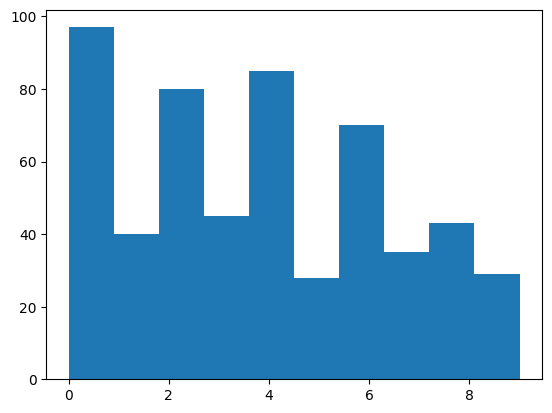

In [82]:
plt.hist(labels,bins=N_CLUSTERS)

In [84]:
from deepexperiment.clustering import compute_cluster_consensus

cluster_consensus = compute_cluster_consensus(miRNA_s, labels)

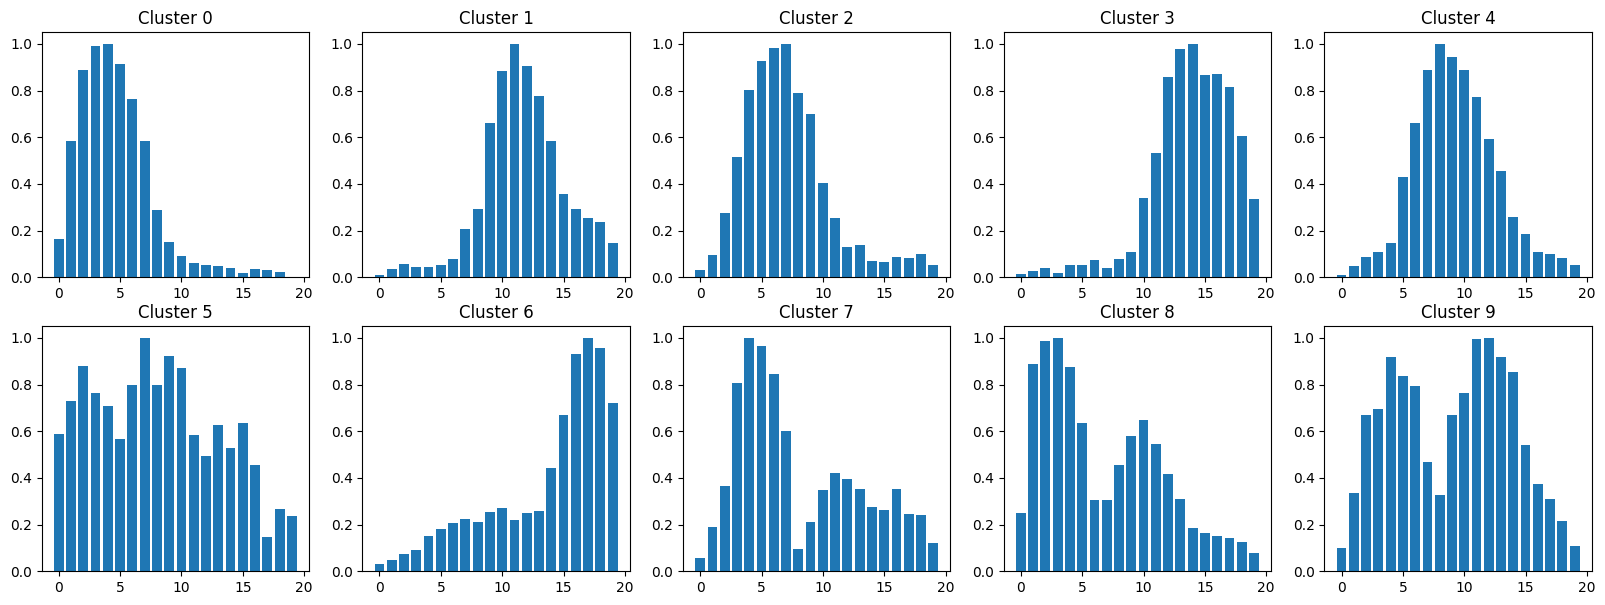

In [100]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))

for i in range(5):
    ax[0,i].bar(range(20), cluster_consensus[i])
    ax[0,i].set_title(f"Cluster {i}")
    ax[1,i].bar(range(20), cluster_consensus[i+5])
    ax[1,i].set_title(f"Cluster {i+5}")